# Merge Tuolumne (Gaylor Pit) and GOES datasets

Read in our Gaylor Pit and GOES datasets, set up the time bounds we want to look at, and resample everything to 5 minute intervals.

Then merge the GOES brightness temperature observations with the Gaylor Pit dataset, and output the merged dataset for analysis elsewhere.

In [1]:
import pandas as pd
import numpy as np
import os
import datetime as dt
import xarray as xr
import glob

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def getListOfFiles(dirName):
    # create a list of file and sub directories 
    # names in the given directory 
    # https://thispointer.com/python-how-to-get-list-of-files-in-directory-and-sub-directories/
    listOfFile = os.listdir(dirName)
    allFiles = list()
    # Iterate over all the entries
    for entry in listOfFile:
        # Create full path
        fullPath = os.path.join(dirName, entry)
        # If entry is a directory then get the list of files in this directory 
        if os.path.isdir(fullPath):
            allFiles = allFiles + getListOfFiles(fullPath)
        else:
            allFiles.append(fullPath)
                
    return allFiles 

---
#### Open Tuolumne (Gaylor Pit) data files:

In [3]:
tuol_df = pd.read_pickle('data/GaylorPit_Temp_Snowdepth_2017-2020.pkl')
# convert to xarray data array
tuol_ds = tuol_df.to_xarray()



In [4]:
tuol_ds

<xarray.Dataset>
Dimensions:     (time: 220800)
Coordinates:
  * time        (time) datetime64[ns] 2015-09-29T10:00:00 ... 2020-08-20T13:30:00
Data variables:
    tss         (time) float64 16.93 17.17 19.73 22.59 ... 43.37 43.81 43.0
    air_temp_c  (time) float64 14.41 14.81 15.89 16.9 ... 22.06 23.0 23.53 23.53
    depth_cm    (time) float64 144.6 1.849 2.017 0.8382 ... 0.9728 -1.214 -1.382

#### Open GOES L1b Radiance observations for the CUES site:
Convert times to UTC-8

In [5]:
# Find all our GOES csv files
directory = '/storage/GOES/pkl/GaylorPit/*.csv'
goes_files = glob.glob(directory)
# Read in the files with pandas
goes = []
_ = [goes.append(pd.read_csv(i)) for i in goes_files]
# concatenate together
goes = pd.concat(goes)
# Change GOES time values from UTC to UTC-8 for CUES site:
goes = goes.rename(columns={'time': 'timeUTC', 'ref_or_tb': 'tb_k'})
goes['time'] = pd.to_datetime(goes.timeUTC)  - pd.Timedelta(hours=8)
goes = goes.drop(columns=['timeUTC'])
# create brightness temperature in C column
goes['tb_c'] = goes.tb_k - 273.15
# Convert pandas dataframe to xarray dataset and and make our local time datetimes the index
_goes = goes.set_index('time')
_goes.sort_index(inplace=True)
goes_ds = _goes.to_xarray()

Find non-orthorectified GOES L1b Radiance observations for comparison:

In [6]:
# Find all our GOES csv files
directory = '/storage/GOES/pkl/GaylorPit_not_orthorectified/*.csv'
goes_files = glob.glob(directory)
# Read in the files with pandas
goes = []
_ = [goes.append(pd.read_csv(i)) for i in goes_files]
# concatenate together
goes = pd.concat(goes)
# Change GOES time values from UTC to UTC-8 for CUES site:
goes = goes.rename(columns={'time': 'timeUTC', 'Rad': 'Rad_not_orthorectified', 'ref_or_tb': 'tb_k_not_orthorectified'})
goes['time'] = pd.to_datetime(goes.timeUTC)  - pd.Timedelta(hours=8)
goes = goes.drop(columns=['timeUTC'])
# create brightness temperature in C column
goes['tb_c_not_orthorectified'] = goes.tb_k_not_orthorectified - 273.15
# Convert pandas dataframe to xarray dataset and and make our local time datetimes the index
_goes = goes.set_index('time')
_goes.sort_index(inplace=True)
goes_not_orthorectified_ds = _goes.to_xarray()

/home/spestana/opt/anaconda3/envs/goes-linux/lib/python3.6/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


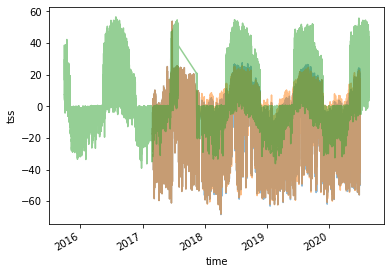

In [7]:
goes_not_orthorectified_ds.tb_c_not_orthorectified.plot(alpha=0.5)
goes_ds.tb_c.plot(alpha=0.5)
tuol_ds.tss.plot(alpha=0.5)

#### Open GOES L2 ABI Cloud Mask observations for the CUES site:
Convert times to UTC-8

---
#### Set time bounds and resample

Select only the overlapping time period we want, and resample all of these to 5 minute means, ignoring any nan values.

(CUES provides ~1-minute observations, GOES is 5- or 10-minute)

In [82]:
startdate = '2017-03-01'
enddate = '2020-06-30'

tuol_ds_5min = tuol_ds.sel(time=slice(startdate, enddate)).resample(time='5min').reduce(np.nanmean)
goes_ds_5min = goes_ds.sel(time=slice(startdate, enddate)).resample(time='5min').reduce(np.nanmean)
goes_not_orthorectified_ds_5min = goes_not_orthorectified_ds.sel(time=slice(startdate, enddate)).resample(time='5min').reduce(np.nanmean)
#goes_acm_5min = goes_acm.sel(datetime=slice(startdate, enddate)).resample(datetime='5min').reduce(np.nanmean)

/home/spestana/opt/anaconda3/envs/goes-linux/lib/python3.6/site-packages/xarray/core/variable.py:1462: RuntimeWarning: Mean of empty slice
  data = func(input_data, axis=axis, **kwargs)


#### Merge the datasets

Merge GOES brightness temperature into the Tuolumne Gaylor Pit dataset

In [83]:
# Match the nearest datetimes
_tuol_ds = tuol_ds_5min.sel(time=goes_ds_5min.time)
_goes_ds = goes_ds_5min.sel(time=_tuol_ds.time)
_goes_not_orthorectified_ds = goes_not_orthorectified_ds_5min.sel(time=_tuol_ds.time)

# assign value to new column in tuolumne gaylor pit dataset
_tuol_ds['goes_tb_c'] = (['time'],  _goes_ds.tb_c)
_tuol_ds['goes_rad'] = (['time'],  _goes_ds.Rad)
_tuol_ds['goes_tb_not_orthorectified_c'] = (['time'],  _goes_not_orthorectified_ds.tb_c_not_orthorectified)
_tuol_ds['goes_rad_not_orthorectified'] = (['time'],  _goes_not_orthorectified_ds.Rad_not_orthorectified)

# rename this
tuol_ds_5min = _tuol_ds

**Additional data cleanup steps:**

Compute daily median snow depth:

* **Resample to the daily median snow depth**. 

* There are still a few erroneous large daily snowdepth values, so finally **filter out depths > 400 cm** since those are larger than any other values in the timeseries. 

* Replace all NaN values with linearly interpolated values. 

* Finally add our cleaned up daily median snow depths to the original dataset.

In [90]:
# Compute initial daily median snow depth at Gaylor Pit
daily_median_snow_depth = tuol_ds_5min.depth_cm.resample(time='1D').median()
# remove depths that are larger than the maximum in the whole 2017-2020 data record I've identified (400 cm)
max_daily_median_snowdepth = 400
daily_median_snow_depth = daily_median_snow_depth.where(daily_median_snow_depth<max_daily_median_snowdepth)
# fill nan values by day (I have to go back to a pandas Dataframe here)
daily_median_snow_depth = daily_median_snow_depth.to_dataframe().loc[tuol_ds_5min.to_dataframe().index].fillna(method='bfill')
# resample back to 5-minute and interpolate to fill missing values
daily_median_snow_depth = daily_median_snow_depth.resample('5min').interpolate('linear')
# finally pull out the values we want, put back into the original dataset as a new variable
tuol_ds_5min['daily_median_snow_depth'] = ('time', daily_median_snow_depth.values.flatten())

/home/spestana/opt/anaconda3/envs/goes-linux/lib/python3.6/site-packages/ipykernel_launcher.py:7: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  import sys


Plot the old snow depth and new daily median snow depth:

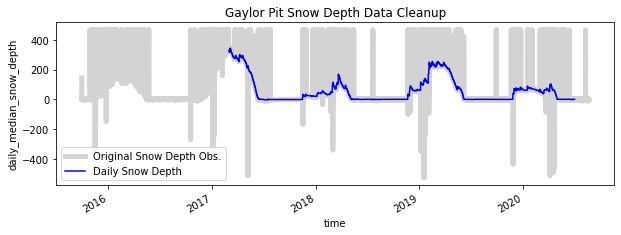

In [94]:
plt.figure(figsize=(10,3))
tuol_ds.depth_cm.plot(linewidth=5, color='lightgrey', label='Original Snow Depth Obs.')
tuol_ds_5min.daily_median_snow_depth.plot(color='b',label='Daily Snow Depth')
plt.title('Gaylor Pit Snow Depth Data Cleanup')
plt.legend();

**Compute difference between GOES Tb and Gaylor Pit Tss**

(GOES Tb - Gaylor Pit Tss) and add it to the dataset

In [96]:
# Orthorectified GOES
tuol_ds_5min['goes_tuol_diff'] = tuol_ds_5min.goes_tb_c - tuol_ds_5min.tss

# Not orthorecitfied, original GOES
tuol_ds_5min['goes_tuol_diff_not_orthorectified'] = tuol_ds_5min.goes_tb_not_orthorectified_c - tuol_ds_5min.tss

**Open the 5-minute GOES-16 ABI Cloud Mask product:**

In [98]:
goes_cloudmask = pd.read_pickle('data/GOES-16_ABI-L2-ACMC_Tuolumne_2017-2020.pkl')
goes_cloudmask = goes_cloudmask.to_xarray()

Round the ABI Cloud Mask timestamps to the nearest minute to match these up with the merged GOES and Tuolumne (5-minute interval) data. Add the cloud mask to the cues_ds (**NOTE**: I have only a shorter time period covered by the cloud mask than the rest of the GOES and Tuol data)

In [100]:
goes_cloudmask['time'] = goes_cloudmask.time.dt.floor('5min')
tuol_ds_5min['ABI_Cloud_Mask'] = goes_cloudmask.BCM

Rename the "datetime" index column to just "time" and add an hour of day and month and week field

In [102]:
# create hour of day field
tuol_ds_5min['hour_of_day'] = tuol_ds_5min.time.dt.hour

# create month field
tuol_ds_5min['month'] = tuol_ds_5min.time.dt.month

# create week field
tuol_ds_5min['week'] = tuol_ds_5min.time.dt.week

#### Export this merged dataset

In [103]:
tuol_ds_5min.to_dataframe().to_pickle('data/goes-tuolumne_2017-2020.pkl')

In [104]:
tuol_ds_5min

<xarray.Dataset>
Dimensions:                            (time: 350688)
Coordinates:
  * time                               (time) datetime64[ns] 2017-03-01 ... 2020-06-30T15:55:00
Data variables:
    tss                                (time) float64 -25.96 nan nan ... nan nan
    air_temp_c                         (time) float64 -16.46 nan nan ... nan nan
    depth_cm                           (time) float64 330.5 nan nan ... nan nan
    goes_tb_c                          (time) float64 -16.34 -16.43 ... 10.77
    goes_rad                           (time) float64 57.37 57.28 ... 92.71
    goes_tb_not_orthorectified_c       (time) float64 -16.34 -16.43 ... 10.31
    goes_rad_not_orthorectified        (time) float64 57.37 57.28 ... 92.02
    daily_median_snow_depth            (time) float64 327.7 322.6 ... 0.7239
    goes_tuol_diff                     (time) float64 9.615 nan nan ... nan nan
    goes_tuol_diff_not_orthorectified  (time) float64 9.615 nan nan ... nan nan
    ABI_Cloud_Mas